In [1]:
import json

bvh_dataset = "./datasets/mocap/dataset_v2.json"
triang_data_file = "./datasets/yolo/triangulation_select.json"
selected_names_file = "./datasets/mediapipe/selected_joint_names.json"
predicted_file = "./datasets/predicted/testset_predicted.json"


with open(bvh_dataset, 'r') as file:
    data_3d = json.load(file)

with open(selected_names_file, 'r') as file:
    selected_names = json.load(file)

with open(triang_data_file, 'r') as file:
    triangulation_data = json.load(file)
    
with open(predicted_file, 'r') as file:
    predicted = json.load(file)

with open("./datasets/train_test_split.json", "r") as f:
    train_test_split = json.load(f)

test_seq_set = train_test_split["test"]
test_seq_set

['p16s1',
 'p16s3',
 'p13s1',
 'p13s3',
 'p4s1',
 'p4s3',
 'p29s5',
 'p29s7',
 'p26s5',
 'p26s7']

In [2]:
sample_seq = test_seq_set[5]
selected_seq = data_3d[sample_seq]

In [3]:
selected_seq[0]

{'lfemur': [-9.464583396911621, 3.9292099475860596, -1.4904797077178955],
 'ltibia': [-9.752921104431152, 2.042238235473633, -1.3305774927139282],
 'lfoot': [-10.042902946472168, 0.23200535774230957, -1.1771550178527832],
 'rfemur': [-9.566808700561523, 3.9019436836242676, -0.3019142150878906],
 'rtibia': [-9.729783058166504, 2.0946755409240723, -0.5061615109443665],
 'rfoot': [-10.190882682800293, 0.24562597274780273, -0.723251461982727],
 'lhumerus': [-9.396688461303711, 6.315095901489258, -1.5557770729064941],
 'lradius': [-9.644747734069824, 4.937878608703613, -1.854464054107666],
 'lwrist': [-9.590337753295898, 4.192430019378662, -1.9038716554641724],
 'rhumerus': [-9.757701873779297, 6.297626495361328, -0.08381891250610352],
 'rradius': [-9.838019371032715, 4.877483367919922, 0.09484358131885529],
 'rwrist': [-9.71130657196045, 4.151291847229004, 0.19689342379570007]}

In [4]:
SCALE_FACTOR = 255

lfoot_height_z = [frame['lfoot'][1]*SCALE_FACTOR for frame in selected_seq]
rfoot_height_z = [frame['rfoot'][1]*SCALE_FACTOR for frame in selected_seq]


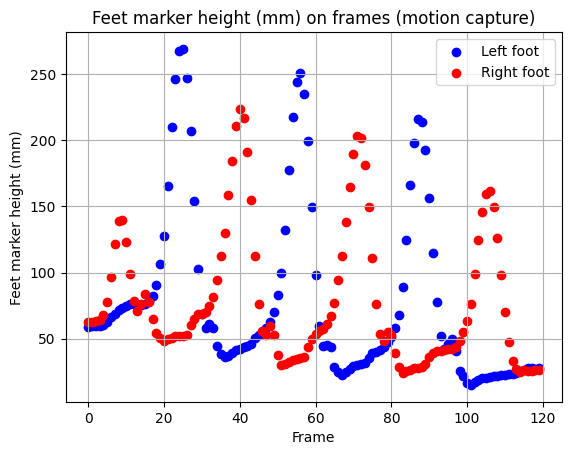

In [5]:
import matplotlib.pyplot as plt

frame_num = [i for i in range(len(lfoot_height_z))]

plt.scatter(frame_num, lfoot_height_z, color='blue', label='Left foot')
plt.scatter(frame_num, rfoot_height_z, color='red', label='Right foot')

plt.title('Feet marker height (mm) on frames (motion capture)')
plt.legend()

plt.xlabel('Frame')
plt.ylabel('Feet marker height (mm)')
plt.grid(True)
plt.show()

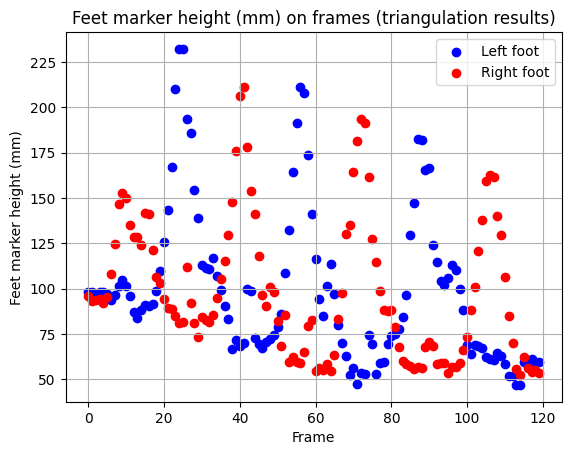

In [6]:
lfoot_height_z_triang = [frame['lfoot'][2] for frame in triangulation_data[sample_seq]]
rfoot_height_z_triang = [frame['rfoot'][2] for frame in triangulation_data[sample_seq]]

frame_num = [i for i in range(len(lfoot_height_z))]

plt.scatter(frame_num, lfoot_height_z_triang, color='blue', label='Left foot')
plt.scatter(frame_num, rfoot_height_z_triang, color='red', label='Right foot')

plt.title('Feet marker height (mm) on frames (triangulation results)')
plt.legend()

plt.xlabel('Frame')
plt.ylabel('Feet marker height (mm)')
plt.grid(True)
plt.show()

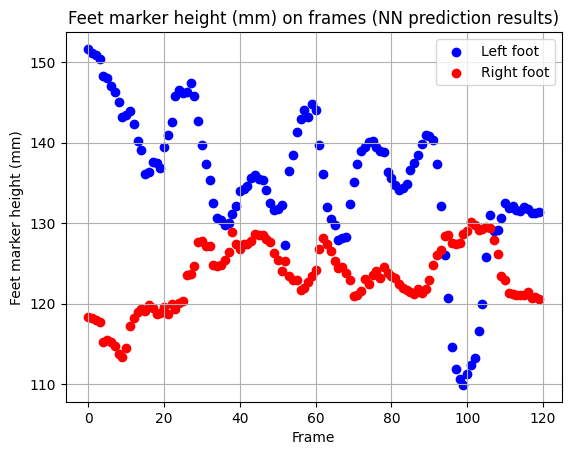

In [7]:
lfoot_height_z_pred = [frame['lfoot'][1] for frame in predicted[sample_seq]]
rfoot_height_z_pred = [frame['rfoot'][1] for frame in predicted[sample_seq]]

frame_num = [i for i in range(len(lfoot_height_z))]

plt.scatter(frame_num, lfoot_height_z_pred, color='blue', label='Left foot')
plt.scatter(frame_num, rfoot_height_z_pred, color='red', label='Right foot')

plt.title('Feet marker height (mm) on frames (NN prediction results)')
plt.legend()

plt.xlabel('Frame')
plt.ylabel('Feet marker height (mm)')
plt.grid(True)
plt.show()

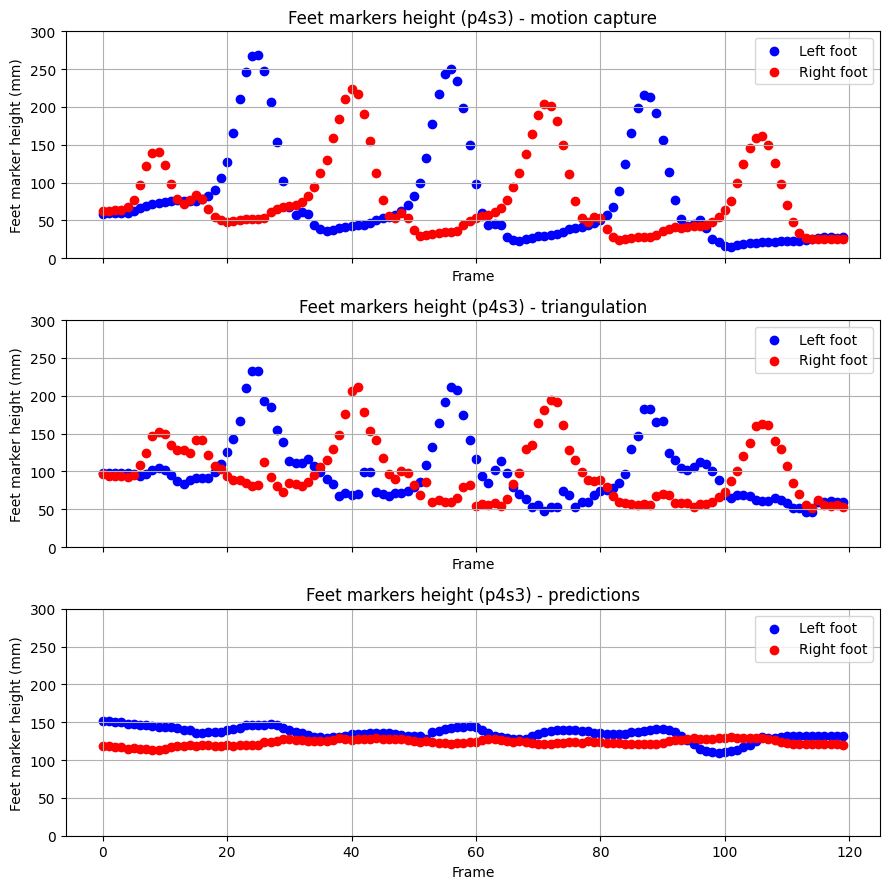

In [8]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(9, 9), sharex=True)
sample_seq = test_seq_set[5]
selected_seq = data_3d[sample_seq]
SCALE_FACTOR = 255

lfoot_height_z = [frame['lfoot'][1]*SCALE_FACTOR for frame in selected_seq]
rfoot_height_z = [frame['rfoot'][1]*SCALE_FACTOR for frame in selected_seq]
frame_num = [i for i in range(len(lfoot_height_z))]
axes[0].scatter(frame_num, lfoot_height_z, color='blue', label='Left foot')
axes[0].scatter(frame_num, rfoot_height_z, color='red', label='Right foot')
axes[0].set_title(f'Feet markers height ({sample_seq}) - motion capture')

lfoot_height_z_triang = [frame['lfoot'][2] for frame in triangulation_data[sample_seq]]
rfoot_height_z_triang = [frame['rfoot'][2] for frame in triangulation_data[sample_seq]]
axes[1].scatter(frame_num, lfoot_height_z_triang, color='blue', label='Left foot')
axes[1].scatter(frame_num, rfoot_height_z_triang, color='red', label='Right foot')
axes[1].set_title(f'Feet markers height ({sample_seq}) - triangulation')

lfoot_height_z_pred = [frame['lfoot'][1] for frame in predicted[sample_seq]]
rfoot_height_z_pred = [frame['rfoot'][1] for frame in predicted[sample_seq]]
axes[2].scatter(frame_num, lfoot_height_z_pred, color='blue', label='Left foot')
axes[2].scatter(frame_num, rfoot_height_z_pred, color='red', label='Right foot')
axes[2].set_title(f'Feet markers height ({sample_seq}) - predictions')

for i in range(3):
    axes[i].legend()
    axes[i].grid(True)
    axes[i].set_xlabel('Frame')
    axes[i].set_ylabel('Feet marker height (mm)')
    axes[i].set_ylim((0, 300))

plt.tight_layout()
plt.savefig('./plots/feet_marker_height_comparison.png')
plt.show()

In [9]:
def find_local_minima(data, window_size=5):
    local_minima_indices = []
    
    for i in range(window_size, len(data) - window_size):
        window_prev = data[i-window_size:i]
        window_next = data[i+1:i+window_size+1]
        current = data[i]
        
        if current < min(window_prev) and current < min(window_next):
            local_minima_indices.append(i)

    return local_minima_indices


print("Local minima indices lfoot:", find_local_minima(lfoot_height_z, 10))

Local minima indices lfoot: [36, 67, 101]


In [10]:
print("Local minima indices rfoot:", find_local_minima(rfoot_height_z, 10))

Local minima indices rfoot: [20, 51, 83]


In [11]:
print("Local minima indices lfoot (triangulated):", find_local_minima(lfoot_height_z_triang, 10))
print("Local minima indices rfoot (triangulated):", find_local_minima(rfoot_height_z_triang, 10))

Local minima indices lfoot (triangulated): [13, 38, 71]
Local minima indices rfoot (triangulated): [29, 60, 95]


In [12]:
print("Local minima indices lfoot (triangulated):", find_local_minima(lfoot_height_z_pred, 10))
print("Local minima indices rfoot (triangulated):", find_local_minima(rfoot_height_z_pred, 10))

Local minima indices lfoot (triangulated): [15, 36, 52, 66, 82, 99]
Local minima indices rfoot (triangulated): [56, 70, 86]


In [13]:
from scripts.parsers import parse_sequences as parse_sequence_info

file_path = 'gait3d\\ListOfSequences.txt'
sequences = parse_sequence_info(file_path)

In [14]:
for sequence, params in sequences.items():
    if params['MoCap_data']:
        lfoot_height_z = [frame['lfoot'][1]*SCALE_FACTOR for frame in data_3d[sequence]]
        rfoot_height_z = [frame['rfoot'][1]*SCALE_FACTOR for frame in data_3d[sequence]]
        left_minima = find_local_minima(lfoot_height_z, 10)
        right_minima = find_local_minima(rfoot_height_z, 10)
        
        sorted_minima = sorted(right_minima + left_minima)
        order = ""

        for minim in sorted_minima:
            if minim in left_minima:
                order += "L"
            else:
                order += "R"

        alternately = True
        for i in range(len(order) - 1):
            if order[i] == order[i+1]:
                alternately = False
                break

        print(f"{sequence} | {'OK' if alternately else 'NO NO NO NO NO' } | {order} | L: {left_minima} | R: {right_minima}")

p1s1 | OK | LRLRLRL | L: [19, 51, 83, 114] | R: [36, 67, 98]
p1s2 | OK | LRLRLR | L: [22, 53, 84] | R: [38, 68, 99]
p1s3 | OK | LRLRLRL | L: [17, 47, 77, 107] | R: [32, 62, 92]
p1s4 | OK | LRLRLR | L: [18, 48, 78] | R: [34, 64, 95]
p2s1 | OK | RLRLRLRL | L: [36, 66, 96, 123] | R: [23, 52, 81, 112]
p2s2 | OK | RLRLRLR | L: [29, 56, 84] | R: [18, 44, 70, 99]
p2s3 | OK | LRLRLRL | L: [19, 48, 76, 106] | R: [34, 63, 91]
p2s4 | OK | LRLRLRLR | L: [10, 35, 61, 88] | R: [23, 50, 74, 103]
p3s1 | OK | LRLRLRLR | L: [16, 48, 78, 104] | R: [35, 64, 94, 127]
p3s2 | OK | RLRLRLR | L: [27, 52, 80] | R: [14, 40, 66, 95]
p3s3 | OK | LRLRLRLR | L: [17, 50, 79, 109] | R: [34, 65, 96, 128]
p3s4 | OK | RLRLRLR | L: [36, 61, 87] | R: [23, 49, 74, 100]
p4s1 | OK | LRLRLR | L: [22, 53, 84] | R: [38, 69, 101]
p4s2 | OK | LRLRLR | L: [20, 51, 81] | R: [37, 67, 97]
p4s3 | OK | RLRLRL | L: [36, 67, 101] | R: [20, 51, 83]
p4s4 | OK | RLRLRL | L: [35, 65, 96] | R: [18, 50, 81]
p5s1 | OK | RLRLRLRL | L: [36, 69, 10

In [47]:
import math
import numpy as np
from dataclasses import dataclass, field, fields
from typing import Sequence, Mapping, Tuple


@dataclass
class CoordinatesIdx:
    x: int = field(default=0)
    y: int = field(default=1)
    z: int = field(default=2)   

    def __post_init__(self):
        assert self.x != self.y
        assert self.x != self.z
        assert self.y != self.z
        for field in fields(self):
            assert getattr(self, field.name) in [0, 1, 2]


class GaitParametersExtractor():
    FPS = 25
    FRAME_TIME = 1/FPS 
    """
    Class to extract basic gait parameters based on 3D frame.
    """
    def __init__(self, sequence_parameters: Sequence[Mapping], coordintates_idx: CoordinatesIdx=CoordinatesIdx, scale_factor:int=255):
        self.seq_params = sequence_parameters
        self.scale_factor = scale_factor
        self.c_idx = coordintates_idx
        self.l_steps, self.r_steps = self._find_step_frames()
        self.all_steps = sorted(self.l_steps + self.r_steps)
        self.start_position, self.finish_position = self._find_start_and_finish_position()

    def _find_start_and_finish_position(self) -> Tuple[Tuple[float, float], Tuple[float, float]]:
        """
        Function to find start and finish position of sequence - useful to obtain 
        """
        start_position = ((self.seq_params[0]['lfoot'][self.c_idx.x] + 
                           self.seq_params[0]['rfoot'][self.c_idx.x]) / 2 * self.scale_factor,
                           (self.seq_params[0]['lfoot'][self.c_idx.y] + 
                           self.seq_params[0]['rfoot'][self.c_idx.y]) / 2 * self.scale_factor)

        finish_position = ((self.seq_params[-1]['lfoot'][self.c_idx.x] + 
                            self.seq_params[-1]['rfoot'][self.c_idx.x]) / 2 * self.scale_factor,
                           (self.seq_params[-1]['lfoot'][self.c_idx.y] + 
                            self.seq_params[-1]['rfoot'][self.c_idx.y]) / 2 * self.scale_factor)

        return start_position, finish_position
                    

    def _find_step_frames(self) -> Tuple[Sequence, Sequence]:
        """
        Function to find step frames (minimum foot marker position in sequence.
        Output as two lists - first with frames number with left foot steps, second for right foot.
        """
        lfoot_height_z = [frame['lfoot'][self.c_idx.z]*SCALE_FACTOR for frame in self.seq_params]
        rfoot_height_z = [frame['rfoot'][self.c_idx.z]*SCALE_FACTOR for frame in self.seq_params]
        left_minima = self.__find_local_minima(lfoot_height_z, 10)
        right_minima = self.__find_local_minima(rfoot_height_z, 10)

        if not self.__check_if_left_right_alternately(left_minima, right_minima):
            # If not left right alternately check without first or last item on list - start and end of sequence might be problematic
            if left_minima[0] <= right_minima[0] and self.__check_if_left_right_alternately(left_minima[1:], right_minima):
                left_minima = left_minima[1:]
                print("First left step recognized as probably marked incorrectly and removed")
            elif right_minima[0] <= left_minima[0] and self.__check_if_left_right_alternately(left_minima, right_minima[1:]):
                right_minima = right_minima[1:]
                print("First right step recognized as probably marked incorrectly and removed")
            elif left_minima[-1] <= right_minima[-1] and self.__check_if_left_right_alternately(left_minima[:-1], right_minima):
                left_minima = left_minima[:-1]
                print("Last left step recognized as probably marked incorrectly and removed")
            elif right_minima[-1] <= left_minima[-1] and self.__check_if_left_right_alternately(left_minima, right_minima[:-1]):
                right_minima = right_minima[:-1]
                print("Last right step recognized as probably marked incorrectly and removed")

        if not self.__check_if_left_right_alternately(left_minima, right_minima):
            print("Falied to find proper step frame keys")
            return [], []

        return left_minima, right_minima

    def calculate_mean_stride_time_and_length(self) -> Sequence[float]:
        """
        Stride time - the time between the consecutive initial contacts of the same foot.
        Stride length - the distance between the consecutive initial contacts of the same foot. 
        Output as six floats: left foot mean stride time, right foot mean stride time, mean stride time,
        left foot mean stride length, right foot mean stride length, mean stride length.
        Time unit is [s], distance unit is [mm].
        """
        
        l_stride_times = []
        l_stride_dist = []
        for i in range(len(self.l_steps)-1):
            l_stride_times.append(self.FRAME_TIME * (self.l_steps[i+1] - self.l_steps[i]))
            l_stride_dist.append(
                self._calculate_distance_between_projections(
                    self.seq_params[self.l_steps[i+1]]['lfoot'],
                    self.seq_params[self.l_steps[i]]['lfoot']
                )
            )

        r_stride_times = []
        r_stride_dist = []
        for i in range(len(self.r_steps)-1):
            r_stride_times.append(self.FRAME_TIME * (self.r_steps[i+1] - self.r_steps[i]))
            r_stride_dist.append(
                self._calculate_distance_between_projections(
                    self.seq_params[self.r_steps[i+1]]['rfoot'],
                    self.seq_params[self.r_steps[i]]['rfoot']
                )
            )

        stride_times = r_stride_times + l_stride_times
        l_mean_stride_time = sum(l_stride_times)/len(l_stride_times)
        r_mean_stride_time = sum(r_stride_times)/len(r_stride_times)
        total_mean_stride_time = sum(stride_times)/len(stride_times)

        stride_dist = r_stride_dist + l_stride_dist
        l_mean_stride_dist = sum(l_stride_dist)/len(l_stride_dist)
        r_mean_stride_dist = sum(r_stride_dist)/len(r_stride_dist)
        total_mean_stride_dist = sum(stride_dist)/len(stride_dist)
        
        return (l_mean_stride_time, r_mean_stride_time, total_mean_stride_time, 
                l_mean_stride_dist, r_mean_stride_dist, total_mean_stride_dist)

    def calculate_mean_step_time_length_and_width(self) -> Sequence[float]:
        """
        Step time - the time between the initial contact of one foot and the initial contact of the contralateral foot.
        Step length - the distance between the initial contact of one foot and the initial contact of the contralateral foot.
        Step width - the distance between the points of initial contact of opposite feet during a step.
        Output as nine floats: left to right foot mean step time, right to left foot mean step time, total mean step time,
        left to right foot mean step length, right to left foot mean step length, total mean step length,
        left to right foot mean step width, right to left foot mean step width, total mean step width.
        Time unit is [s], distance unit is [mm].
        """

        step_times = []
        l_r_step_dist = []
        r_l_step_dist = []
        l_r_step_width = []
        r_l_step_width = []
        for i in range(len(self.all_steps)-1):
            step_times.append(self.FRAME_TIME * (self.all_steps[i+1] - self.all_steps[i]))
            if self.all_steps[i] in self.l_steps:
                l_r_step_dist.append(
                    self._calculate_distance_between_projections(
                        self.seq_params[self.all_steps[i]]['lfoot'],
                        self.seq_params[self.all_steps[i+1]]['rfoot'],
                    )
                )

                l_r_step_width.append(
                    self._calculate_distance_to_gait_axis(self.seq_params[self.all_steps[i+1]]['rfoot']) + 
                    self._calculate_distance_to_gait_axis(self.seq_params[self.all_steps[i]]['lfoot'])
                )

                
            else:
                r_l_step_dist.append(
                    self._calculate_distance_between_projections(
                        self.seq_params[self.all_steps[i]]['rfoot'],
                        self.seq_params[self.all_steps[i+1]]['lfoot'],
                    )
                )

                r_l_step_width.append(
                    self._calculate_distance_to_gait_axis(self.seq_params[self.all_steps[i+1]]['lfoot']) + 
                    self._calculate_distance_to_gait_axis(self.seq_params[self.all_steps[i]]['rfoot'])
                )

        if self.all_steps[0] == self.l_steps[0]:
            l_r_step_time = step_times[0::2]
            r_l_step_time = step_times[1::2]
        else:
            l_r_step_time = step_times[1::2]
            r_l_step_time = step_times[0::2]

        l_r_mean_step_times = sum(l_r_step_time)/len(l_r_step_time)
        r_l_mean_step_times = sum(r_l_step_time)/len(r_l_step_time)
        total_mean_step_times = sum(step_times)/len(step_times)

        step_dist = l_r_step_dist + r_l_step_dist
        total_mean_step_distance = sum(step_dist)/len(step_dist)
        l_r_mean_step_dist = sum(l_r_step_dist)/len(l_r_step_dist)
        r_l_mean_step_dist = sum(r_l_step_dist)/len(r_l_step_dist)

        step_width = l_r_step_width + r_l_step_width
        total_mean_step_width = sum(step_width)/len(step_width)
        l_r_mean_step_width = sum(l_r_step_width)/len(l_r_step_width)
        r_l_mean_step_width = sum(r_l_step_width)/len(r_l_step_width)
        
        return (l_r_mean_step_times, r_l_mean_step_times, total_mean_step_times, 
                l_r_mean_step_dist, r_l_mean_step_dist, total_mean_step_distance,
                l_r_mean_step_width, r_l_mean_step_width, total_mean_step_width)

    def _calculate_distance_to_gait_axis(self, point: Sequence[float]) -> float:
        """
        Calculate the distance from given point to the line defined by start and end participant position.
        Each point is a tuple of (x, y).
        """
        x1, y1 = self.start_position
        x2, y2 = self.finish_position

        x0, y0 = (point[self.c_idx.x] * self.scale_factor, point[self.c_idx.y] * self.scale_factor)
        
        numerator = abs((x2 - x1) * (y1 - y0) - (x1 - x0) * (y2 - y1))
        denominator = math.hypot(x2 - x1, y2 - y1)
                
        return numerator / denominator

    def _project_point_onto_line(self, point: Tuple[float, float]) -> Tuple[float, float]:
        """
        Projects a point onto the line defined by p_start and p_stop.
        """
        p_start = np.array(self.start_position)
        p_stop = np.array(self.finish_position)
        point = np.array(point)
        
        line_vec = p_stop - p_start
        line_unit = line_vec / np.linalg.norm(line_vec)
        
        point_vec = point - p_start
        projection_length = np.dot(point_vec, line_unit)
        
        projection = p_start + projection_length * line_unit
        return projection

    def _calculate_distance_between_projections(self, point_a: Sequence[float], point_b: Sequence[float]):
        """
        Projects a and b onto the line through start and finish position, 
        and returns the distance between those projections.
        """
        
        proj_a = self._project_point_onto_line((point_a[self.c_idx.x] * self.scale_factor, point_a[self.c_idx.y] * self.scale_factor))
        proj_b = self._project_point_onto_line((point_b[self.c_idx.x] * self.scale_factor, point_b[self.c_idx.y] * self.scale_factor))
        
        return np.linalg.norm(proj_b - proj_a)


    @staticmethod
    def __find_local_minima(data, window_size:int=5) -> Sequence[int]:
        local_minima_indices = []
        
        for i in range(window_size, len(data) - window_size):
            window_prev = data[i-window_size:i]
            window_next = data[i+1:i+window_size+1]
            current = data[i]
            
            if current < min(window_prev) and current < min(window_next):
                local_minima_indices.append(i)
    
        return local_minima_indices

    @staticmethod
    def __check_if_left_right_alternately(left_minima, right_minima):
        sorted_minima = sorted(right_minima + left_minima)
        order=""

        for minim in sorted_minima:
            if minim in left_minima:
                order += "L"
            else:
                order += "R"

        alternately = True
        for i in range(len(order) - 1):
            if order[i] == order[i+1]:
                alternately = False
                break

        return alternately

    import numpy as np

    @staticmethod
    def __project_point_on_plane(point, plane_point, plane_normal):
        """
        Projects a 3D point onto a plane.Returns projected 3D point on the plane.
        """
        plane_normal = plane_normal / np.linalg.norm(plane_normal)
        vector_to_point = point - plane_point
        distance = np.dot(vector_to_point, plane_normal)
        projected_point = point - distance * plane_normal
        return projected_point
        
    @staticmethod
    def __angle_between_vectors(v1, v2):
        """
        Calculates the angle in degrees between two 3D vectors.
        """
        dot_product = np.dot(v1, v2)
        magnitude_v1 = np.linalg.norm(v1)
        magnitude_v2 = np.linalg.norm(v2)
    
        if magnitude_v1 == 0 or magnitude_v2 == 0:
            return 0.0
    
        cosine_angle = dot_product / (magnitude_v1 * magnitude_v2)
        cosine_angle = np.clip(cosine_angle, -1.0, 1.0)
        angle_rad = np.arccos(cosine_angle)
        angle_deg = np.degrees(angle_rad)
        return angle_deg

    @staticmethod
    def _mean(sequence: list) -> float:
        return sum(sequence)/len(sequence)

    def _calculate_angle_between_joints(self, joint_pair_1:tuple, joint_pair_2:tuple, frame_number:int):
        p1 = np.array([self.start_position[0], self.start_position[1], 0.0])
        p2 = np.array([self.start_position[0], self.start_position[1], 1.0])
        p3 = np.array([self.finish_position[0], self.finish_position[1], 0.0])
        
        A_orig = np.array(self.seq_params[frame_number][joint_pair_1[0]]) * self.scale_factor
        B_orig = np.array(self.seq_params[frame_number][joint_pair_1[1]]) * self.scale_factor
        C_orig = np.array(self.seq_params[frame_number][joint_pair_2[0]]) * self.scale_factor
        D_orig = np.array(self.seq_params[frame_number][joint_pair_2[1]]) * self.scale_factor

        new_order_indices = [self.c_idx.x, self.c_idx.y, self.c_idx.z]

        A = A_orig[new_order_indices]
        B = B_orig[new_order_indices]
        C = C_orig[new_order_indices]
        D = D_orig[new_order_indices]
        
        v1 = p2 - p1
        v2 = p3 - p1
        plane_normal = np.cross(v1, v2)
        
        if np.linalg.norm(plane_normal) == 0:
            print("Error: The points p1, p2, and p3 are collinear and do not define a unique plane.")
            return 0
        else:
            A_proj = self.__project_point_on_plane(A, p1, plane_normal)
            B_proj = self.__project_point_on_plane(B, p1, plane_normal)
            C_proj = self.__project_point_on_plane(C, p1, plane_normal)
            D_proj = self.__project_point_on_plane(D, p1, plane_normal)
        
            # print(f"Original A: {A}, Projected A: {A_proj}")
            # print(f"Original B: {B}, Projected B: {B_proj}")
            # print(f"Original C: {C}, Projected C: {C_proj}")
            # print(f"Original D: {D}, Projected D: {D_proj}")
        
            line1_direction = B_proj - A_proj
            line2_direction = D_proj - C_proj
        
            if np.linalg.norm(line1_direction) == 0 or np.linalg.norm(line2_direction) == 0:
                print("One or both projected lines are effectively points (start and end points are the same). Angle is undefined or 0.")
                return 0
            else:
                angle = self.__angle_between_vectors(line1_direction, line2_direction)
                return angle

    def get_legs_angle(self):
        legs_angles = []
        for i in range(len(self.seq_params)):
            legs_angles.append(self._calculate_angle_between_joints(('rtibia','rfemur'), ('ltibia', 'lfemur'), i))
        return legs_angles

    def get_knees_angle(self):
        l_knee_angles = []
        r_knee_angles = []
        for i in range(len(self.seq_params)):
            r_knee_angles.append(self._calculate_angle_between_joints(('rfemur', 'rtibia'), ('rfoot', 'rtibia'), i))
            l_knee_angles.append(self._calculate_angle_between_joints(('lfemur', 'ltibia'), ('lfoot', 'ltibia'), i))
        return l_knee_angles, r_knee_angles

    def get_hip_angle(self):
        l_hip_angles = []
        r_hip_angles = []
        for i in range(len(self.seq_params)):
            r_hip_angles.append(self._calculate_angle_between_joints(('rhumerus', 'rfemur'), ('rtibia', 'rfemur'), i))
            l_hip_angles.append(self._calculate_angle_between_joints(('lhumerus', 'lfemur'), ('ltibia', 'lfemur'), i))
        return l_hip_angles, r_hip_angles

    def calculate_avg_max_hip_angle_per_stride(self) -> tuple[float, float, float]:
        """
        Calculate max hip angle for each step in sequence
        Returns mean of those max hip angle for steps of left, right and both feet.
        """
        
        l_hip_angles, r_hip_angles = self.get_hip_angle()
        l_max_hip_angle_diff, r_max_hip_angle_diff, = [], [] 
       
        for i in range(len(self.l_steps)-1):
            l_max_hip_angle_diff.append(
                max(l_hip_angles[self.l_steps[i]: self.l_steps[i+1]])
                - min(l_hip_angles[self.l_steps[i]: self.l_steps[i+1]])
            )

        for i in range(len(self.r_steps)-1):
            r_max_hip_angle_diff.append(
                max(r_hip_angles[self.r_steps[i]: self.r_steps[i+1]])
                - min(r_hip_angles[self.r_steps[i]: self.r_steps[i+1]])
            )
        
        return self._mean(l_max_hip_angle_diff), self._mean(r_max_hip_angle_diff), self._mean(l_max_hip_angle_diff + r_max_hip_angle_diff)

    def calculate_avg_max_knee_angle_per_stride(self) -> tuple[float, float, float]:
        """
        Calculate max knee angle for each stride in sequence
        Returns mean of those max knee angle for steps of left, right and both feet.
        """
        
        l_knee_angles, r_knee_angles = self.get_knees_angle()
        l_max_knee_angle_diff, r_max_knee_angle_diff, = [], [] 
       
        for i in range(len(self.l_steps)-1):
            l_max_knee_angle_diff.append(
                max(l_knee_angles[self.l_steps[i]: self.l_steps[i+1]])
                - min(l_knee_angles[self.l_steps[i]: self.l_steps[i+1]])
            )

        for i in range(len(self.r_steps)-1):
            r_max_knee_angle_diff.append(
                max(r_knee_angles[self.r_steps[i]: self.r_steps[i+1]])
                - min(r_knee_angles[self.r_steps[i]: self.r_steps[i+1]])
            )

        return self._mean(l_max_knee_angle_diff), self._mean(r_max_knee_angle_diff), self._mean(l_max_knee_angle_diff + r_max_knee_angle_diff)

    def calculate_avg_max_legs_angle_for_steps(self) -> tuple[float, float, float]:
        """
        Calculate max legs angle in each step.
        Returns mean max legs angle for left to right foot step, right to left foot step and all steps.
        """
        l_r_step_l_angle, r_l_step_l_angle = [], []
        legs_angle = self.get_legs_angle()
        for i in range(len(self.all_steps)-1):
            if self.all_steps[i] in self.l_steps:
                l_r_step_l_angle.append(
                    max(legs_angle[self.all_steps[i]], legs_angle[self.all_steps[i]+1])
                )

            else:
                r_l_step_l_angle.append(
                    max(legs_angle[self.all_steps[i]], legs_angle[self.all_steps[i]+1])
                )

        return  self._mean(l_r_step_l_angle), self._mean(r_l_step_l_angle), self._mean(r_l_step_l_angle + l_r_step_l_angle)


In [48]:
for i in range(1, 9):
    print(f'p30s{i}')
    gpe = GaitParametersExtractor(data_3d[f'p30s{i}'], CoordinatesIdx(2, 0, 1))
    # print(gpe.start_position, gpe.finish_position)
    # print(gpe.l_steps, gpe.r_steps)
    print(gpe.calculate_mean_stride_time_and_length())
    print(gpe.calculate_mean_step_time_length_and_width())
    print(gpe.calculate_avg_max_hip_angle_per_stride())
    print(gpe.calculate_avg_max_knee_angle_per_stride())
    print(gpe.calculate_avg_max_legs_angle_for_steps())
    

p30s1
(1.1600000000000001, 1.12, 1.1400000000000001, 1625.8909585933586, 1620.924113727207, 1623.4075361602827)
(0.54, 0.6000000000000001, 0.5760000000000001, 819.9319001434092, 814.7837380682289, 816.8430028983009, 132.65444764739223, 133.4605871492988, 133.13813134853618)
(20.98943915183152, 34.043459220112894, 27.516449185972206)
(67.09555051236927, 72.67961912302789, 69.88758481769858)
(43.09027509163733, 28.83004541296075, 37.3861832201667)
p30s2
(1.1, 1.08, 1.09, 1653.0932912441785, 1628.9493104724447, 1641.0213008583116)
(0.54, 0.56, 0.552, 839.8028264356335, 807.7380733636131, 820.5639745924212, 161.01829421170763, 139.7984904432146, 148.2864119506118)
(20.658463564704633, 31.382222936194182, 26.020343250449407)
(68.87867172943314, 74.53878320862034, 71.70872746902674)
(44.84834540082496, 35.90458347346925, 41.27084062988268)
p30s3
(1.0933333333333335, 1.0, 1.0466666666666666, 1398.5793824253467, 1486.1400912954116, 1442.359736860379)
(0.5466666666666667, 0.49, 0.51428571428571

In [56]:
feature_names = "l_mean_stride_time, r_mean_stride_time, total_mean_stride_time, \
l_mean_stride_dist, r_mean_stride_dist, total_mean_stride_dist, l_r_mean_step_times, \
r_l_mean_step_times, total_mean_step_times, l_r_mean_step_dist, r_l_mean_step_dist, \
total_mean_step_distance, l_r_mean_step_width, r_l_mean_step_width, total_mean_step_width, \
l_mean_max_hip_angle_diff, r_mean_max_hip_angle_diff, total_mean_max_hip_angle_diff, \
l_mean_max_knee_angle_diff, r_mean_max_knee_angle_diff, total_mean_max_knee_angle_diff, \
l_r_mean_step_l_angle, r_l_mean_step_l_angle, total_mean_step_l_angle".replace(' ', '').split(',')

len(feature_names)

24

In [58]:
import pandas as pd

sequence_features = []
sequence_participants = []

for seq_key in data_3d.keys():
    participant = seq_key[1:-2]
    gpe = GaitParametersExtractor(data_3d[seq_key], CoordinatesIdx(2, 0, 1))
    features = (gpe.calculate_mean_stride_time_and_length()
                + gpe.calculate_mean_step_time_length_and_width()
                + gpe.calculate_avg_max_hip_angle_per_stride()
                + gpe.calculate_avg_max_knee_angle_per_stride()
                + gpe.calculate_avg_max_legs_angle_for_steps())

    sequence_participants.append(participant)
    sequence_features.append(features)

df = pd.DataFrame(sequence_features, columns=feature_names)
df['participant'] = sequence_participants

df.to_csv('./datasets/gait_features.csv', index=False)

First left step recognized as probably marked incorrectly and removed
First right step recognized as probably marked incorrectly and removed


In [17]:
gpe = GaitParametersExtractor(data_3d['p4s3'], CoordinatesIdx(2, 0, 1))

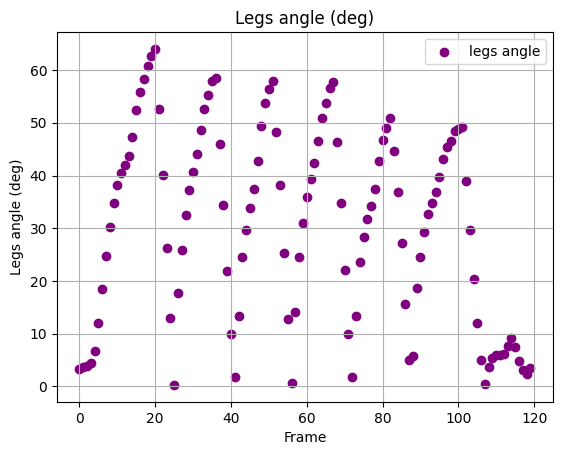

In [18]:
import matplotlib.pyplot as plt

lg = gpe.get_legs_angle()

frame_num = [i for i in range(len(lg))]

plt.scatter(frame_num, lg, color='purple', label='legs angle')

plt.title('Legs angle (deg)')
plt.legend()

plt.xlabel('Frame')
plt.ylabel('Legs angle (deg)')
plt.grid(True)
plt.show()

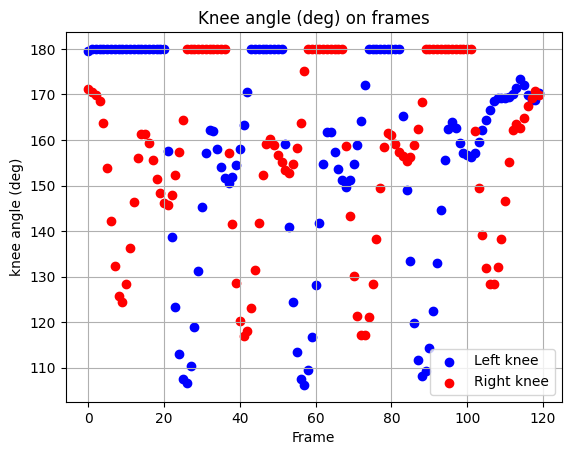

In [19]:
lk, rk = gpe.get_knees_angle()

frame_num = [i for i in range(len(lk))]

plt.scatter(frame_num, lk, color='blue', label='Left knee')
plt.scatter(frame_num, rk, color='red', label='Right knee')

plt.title('Knee angle (deg) on frames')
plt.legend()

plt.xlabel('Frame')
plt.ylabel('knee angle (deg)')
plt.grid(True)
plt.show()

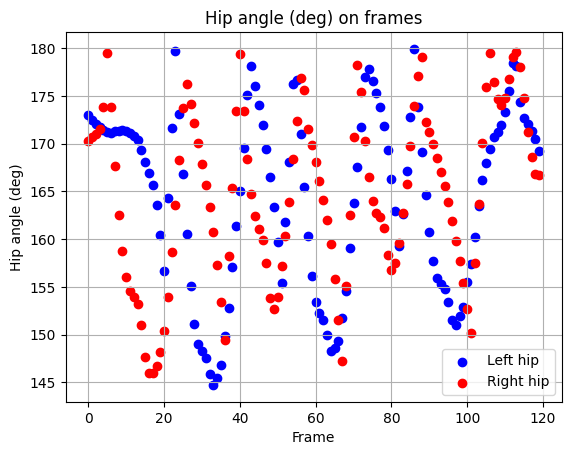

In [20]:
lh, rh = gpe.get_hip_angle()

frame_num = [i for i in range(len(lk))]

plt.scatter(frame_num, lh, color='blue', label='Left hip')
plt.scatter(frame_num, rh, color='red', label='Right hip')
# plt.plot(frame_num, re, color='red', label='Right elbow')

plt.title('Hip angle (deg) on frames')
plt.legend()

plt.xlabel('Frame')
plt.ylabel('Hip angle (deg)')
plt.grid(True)
plt.show()

Falied to find proper step frame keys


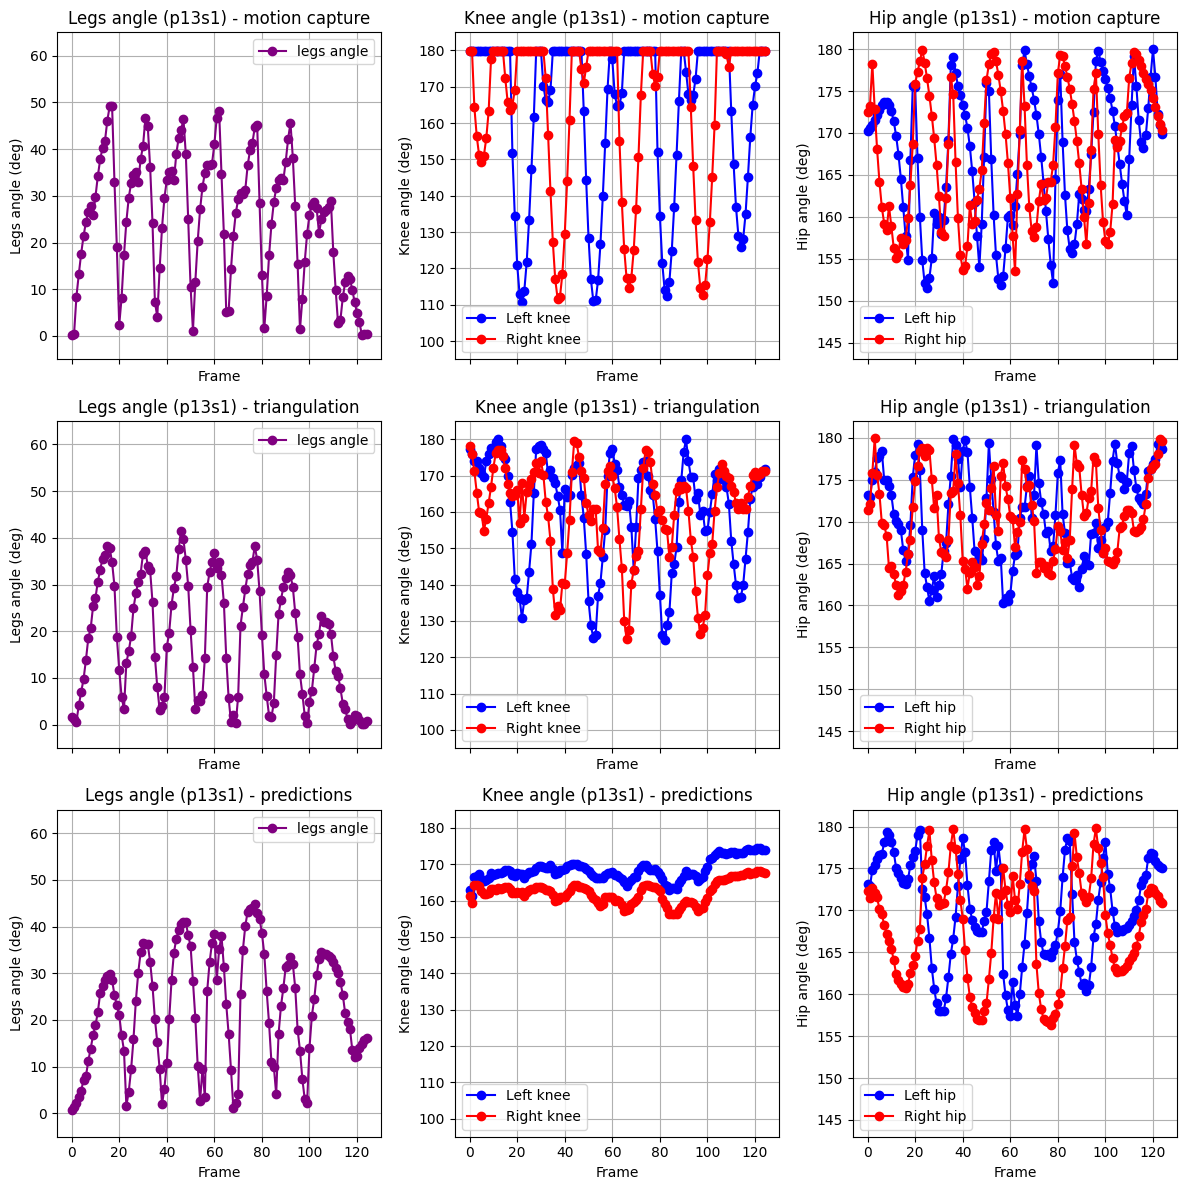

In [21]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12), sharex=True)
sample_seq = test_seq_set[5]
selected_seq = data_3d[sample_seq]
SCALE_FACTOR = 255

sequence_key = 'p13s1'

gpe = GaitParametersExtractor(data_3d[sequence_key], CoordinatesIdx(2, 0, 1))

lg = gpe.get_legs_angle()
frame_num = [i for i in range(len(lg))]
axes[0][0].plot(frame_num, lg, color='purple', marker='o', label='legs angle')
axes[0][0].set_title(f'Legs angle ({sequence_key}) - motion capture')
axes[0][0].set_ylabel('Legs angle (deg)')

lk, rk = gpe.get_knees_angle()
axes[0][1].plot(frame_num, lk, color='blue', marker='o', label='Left knee')
axes[0][1].plot(frame_num, rk, color='red', marker='o', label='Right knee')
axes[0][1].set_title(f'Knee angle ({sequence_key}) - motion capture')
axes[0][1].set_ylabel('Knee angle (deg)')

lh, rh = gpe.get_hip_angle()
axes[0][2].plot(frame_num, lh, color='blue', marker='o', label='Left hip')
axes[0][2].plot(frame_num, rh, color='red', marker='o', label='Right hip')
axes[0][2].set_title(f'Hip angle ({sequence_key}) - motion capture')
axes[0][2].set_ylabel('Hip angle (deg)')

gpe = GaitParametersExtractor(triangulation_data[sequence_key], CoordinatesIdx(0, 1, 2))

lg = gpe.get_legs_angle()
frame_num = [i for i in range(len(lg))]
axes[1][0].plot(frame_num, lg, color='purple', marker='o', label='legs angle')
axes[1][0].set_title(f'Legs angle ({sequence_key}) - triangulation')
axes[1][0].set_ylabel('Legs angle (deg)')

lk, rk = gpe.get_knees_angle()
axes[1][1].plot(frame_num, lk, color='blue', marker='o', label='Left knee')
axes[1][1].plot(frame_num, rk, color='red', marker='o', label='Right knee')
axes[1][1].set_title(f'Knee angle ({sequence_key}) - triangulation')
axes[1][1].set_ylabel('Knee angle (deg)')

lh, rh = gpe.get_hip_angle()
axes[1][2].plot(frame_num, lh, color='blue', marker='o', label='Left hip')
axes[1][2].plot(frame_num, rh, color='red', marker='o', label='Right hip')
axes[1][2].set_title(f'Hip angle ({sequence_key}) - triangulation')
axes[1][2].set_ylabel('Hip angle (deg)')

gpe = GaitParametersExtractor(predicted[sequence_key], CoordinatesIdx(2, 0, 1))

lg = gpe.get_legs_angle()
frame_num = [i for i in range(len(lg))]
axes[2][0].plot(frame_num, lg, color='purple', marker='o', label='legs angle')
axes[2][0].set_title(f'Legs angle ({sequence_key}) - predictions')
axes[2][0].set_ylabel('Legs angle (deg)')

lk, rk = gpe.get_knees_angle()
axes[2][1].plot(frame_num, lk, color='blue', marker='o', label='Left knee')
axes[2][1].plot(frame_num, rk, color='red', marker='o', label='Right knee')
axes[2][1].set_title(f'Knee angle ({sequence_key}) - predictions')
axes[2][1].set_ylabel('Knee angle (deg)')

lh, rh = gpe.get_hip_angle()
axes[2][2].plot(frame_num, lh, color='blue', marker='o', label='Left hip')
axes[2][2].plot(frame_num, rh, color='red', marker='o', label='Right hip')
axes[2][2].set_title(f'Hip angle ({sequence_key}) - predictions')
axes[2][2].set_ylabel('Hip angle (deg)')


for i in range(3):
    for j in range(3):
        axes[i][j].legend()
        axes[i][j].grid(True)
        axes[i][j].set_xlabel('Frame')

        match j:
            case 0:
                 axes[i][j].set_ylim((-5, 65))
            case 1:
                 axes[i][j].set_ylim((95, 185))
                 axes[i][j].legend(loc='lower left')
            case 2:
                axes[i][j].set_ylim((143, 182))

plt.tight_layout()
# plt.savefig('./plots/angle_params_comparison.png')
plt.show()

In [22]:
name_dict = {
    'rhumerus': 'Right shoulder',
    'lhumerus':'Left shoulder',
    'rfemur':'Right hip',
    'lfemur':'Left hip',
    'rtibia':'Right knee',
    'ltibia':'Left knee',
    'rfoot':'Right ankle',
    'lfoot':'Left ankle'
}

In [23]:
errors = {aprox_type: {joint_key: [] for joint_key in name_dict.keys()} for aprox_type in ['triang', 'unique', 'cloth_change']}

for i, sequence_key in enumerate(test_seq_set):
    if i > 6:
        pred_type = 'cloth_change'
    else:
        pred_type = 'unique'

    for frame_true, frame_triang, frame_pred in zip(data_3d[sequence_key], triangulation_data[sequence_key], predicted[sequence_key]):
        for joint_key in name_dict.keys():
            errors[pred_type][joint_key].append(np.linalg.norm(np.array(frame_true[joint_key]) * 255 - np.array(frame_pred[joint_key])))
            errors['triang'][joint_key].append(np.linalg.norm(np.array(frame_true[joint_key]) * 255 - np.array(frame_triang[joint_key])[[1, 2, 0]]))


mean_errors = {aprox_type: {} for aprox_type in ['triang', 'unique', 'cloth_change']}

for aprox_type in ['triang', 'unique', 'cloth_change']:
    for joint_key in name_dict.keys():
        temp_errors = errors[aprox_type][joint_key]
        mean_error = sum(temp_errors)/len(temp_errors)
        print(f"{aprox_type} {joint_key} : {mean_error}")
        mean_errors[aprox_type][joint_key] = mean_error

triang rhumerus : 75.21293761523911
triang lhumerus : 78.15342832160869
triang rfemur : 84.40056613692605
triang lfemur : 80.99179724902193
triang rtibia : 71.22952996533802
triang ltibia : 77.51396917081787
triang rfoot : 61.26783791873037
triang lfoot : 61.2431689638612
unique rhumerus : 275.86148816520813
unique lhumerus : 267.02194194097876
unique rfemur : 253.32792762761153
unique lfemur : 244.83507568737096
unique rtibia : 256.57961373627364
unique ltibia : 252.4519031929727
unique rfoot : 276.8029950606679
unique lfoot : 261.35314825110083
cloth_change rhumerus : 217.74709100097502
cloth_change lhumerus : 228.01583810956078
cloth_change rfemur : 213.27311609881332
cloth_change lfemur : 198.1226972124621
cloth_change rtibia : 217.35232822201502
cloth_change ltibia : 205.09382491790822
cloth_change rfoot : 229.1537806902672
cloth_change lfoot : 214.50107955822526


In [24]:
mean_errors

{'triang': {'rhumerus': 75.21293761523911,
  'lhumerus': 78.15342832160869,
  'rfemur': 84.40056613692605,
  'lfemur': 80.99179724902193,
  'rtibia': 71.22952996533802,
  'ltibia': 77.51396917081787,
  'rfoot': 61.26783791873037,
  'lfoot': 61.2431689638612},
 'unique': {'rhumerus': 275.86148816520813,
  'lhumerus': 267.02194194097876,
  'rfemur': 253.32792762761153,
  'lfemur': 244.83507568737096,
  'rtibia': 256.57961373627364,
  'ltibia': 252.4519031929727,
  'rfoot': 276.8029950606679,
  'lfoot': 261.35314825110083},
 'cloth_change': {'rhumerus': 217.74709100097502,
  'lhumerus': 228.01583810956078,
  'rfemur': 213.27311609881332,
  'lfemur': 198.1226972124621,
  'rtibia': 217.35232822201502,
  'ltibia': 205.09382491790822,
  'rfoot': 229.1537806902672,
  'lfoot': 214.50107955822526}}

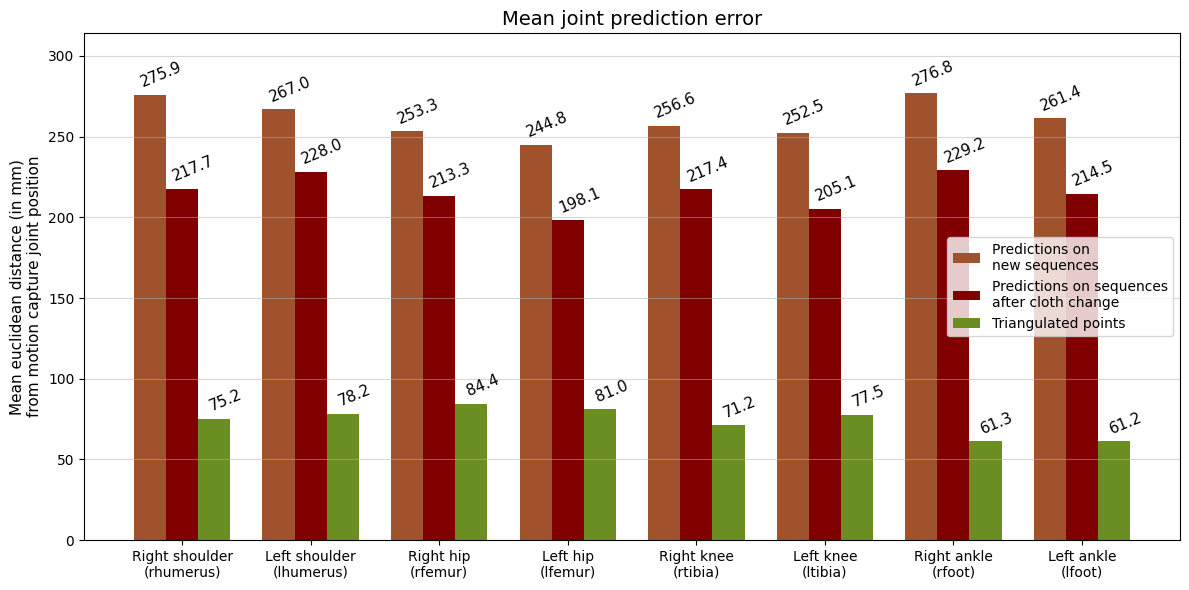

In [25]:
body_parts = list(name_dict.keys())
categories = ['Predictions on\nnew sequences', 'Predictions on sequences\nafter cloth change', 'Triangulated points']
colors = ['sienna', 'maroon', 'olivedrab']
labels = [f"{full_name}\n({key})" for key, full_name in name_dict.items()]
n_parts = len(body_parts)
x = np.arange(n_parts)
width = 0.25  

triang_values = [mean_errors['triang'][bp] for bp in body_parts]
unique_values = [mean_errors['unique'][bp] for bp in body_parts]
cloth_values = [mean_errors['cloth_change'][bp] for bp in body_parts]

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width, unique_values, width, label=categories[0], color=colors[0])
bars2 = ax.bar(x, cloth_values, width, label=categories[1], color=colors[1])
bars3 = ax.bar(x + width, triang_values, width, label=categories[2], color=colors[2])

def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2. + 0.09 , height + 3, f'{height:.1f}',
                ha='center', va='bottom', fontsize=11, rotation=22.5)

add_labels(bars1)
add_labels(bars2)
add_labels(bars3)

ax.set_ylabel('Mean euclidean distance (in mm)\nfrom motion capture joint position', fontsize=11)
ax.set_title('Mean joint prediction error', fontsize=14)
ax.set_xticks(x)
ax.set_ylim((0, 314))
ax.set_xticklabels(labels)
ax.legend()
ax.grid(axis='y', alpha=0.5)

plt.tight_layout()
# plt.savefig('./plots/error_by_joint.png')
plt.show()